# Code for competition

Libraries imports and initializations

In [12]:
import tensorflow as tf
import numpy as np
import os, os.path
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle, class_weight
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#import visualkeras

import models_tests as simonnet

tfk = tf.keras
tfkl = tf.keras.layers
print(f"Tensorflow version = ", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

Tensorflow version =  2.10.0
Num GPUs Available:  1


In [13]:
train_split = 0.8

path = os.getcwd()
if not os.path.exists(path+'/training') and not os.path.exists(path+'/validation'):
    os.mkdir(path+'/training')
    os.mkdir(path+'/validation')

    # Destination path 
    dest_train = path + '/training'
    dest_valid = path + '/validation'

    # Source path
    source = path + '/training_data_final'

    # Create train and validation into the training and validation folders
    for folder in os.listdir(source):
        if not os.path.exists(dest_train + '/' + folder):
            os.mkdir(dest_train + '/' + folder)
        if not os.path.exists(dest_valid + '/' + folder):
            os.mkdir(dest_valid + '/' + folder)
    
        class_source = source + '/' + folder                                                   # Create path of the class
        files = os.listdir(class_source)                                                       # List of files for the class
        random.shuffle(files)
        
        # Create training set randomly
        for i in range(int(len(files) * train_split)):
            dest = shutil.copy(class_source+'/'+files[i], dest_train+'/'+folder+'/'+files[i])  # Copy an image in the training set
        
        # Create validation set randomly
        for j in range(i + 1, len(files)):
            dest = shutil.copy(class_source+'/'+files[j], dest_valid+'/'+folder+'/'+files[j])  # copy an image in the validation set

In [14]:
input_shape = (96, 96, 3)
input_size = input_shape[:-1]
batch_size = 128
epochs = 400
classes = ["Species1", "Species2", "Species3", "Species4", "Species5", "Species6", "Species7", "Species8"]

Load the dataset

In [15]:
samples = []
targets = []

images_ind = [186, 532, 515, 511, 531, 222, 537, 508]

dest_valid = os.getcwd() + '/validation'

i=0
for folder in os.listdir(dest_valid):
    dest_class = dest_valid + '/' + folder
    for img in os.listdir(dest_class):
        temp = Image.open(dest_class + '/' + img).convert('RGB')
        image = np.squeeze(np.expand_dims(temp, axis=0)) / 255
        label = tfk.utils.to_categorical(i, len(classes))
        samples.append(image)
        targets.append(label)
    i += 1

# creation of augmented dataset 
X = np.array(samples)
y = np.array(targets, dtype=np.uint8)
print(X.shape, y.shape)
print(X.dtype, y.dtype, sep=", ")

(713, 96, 96, 3) (713, 8)
float64, uint8


Models metadata

In [16]:

labels = {0: "Species1", 1: "Species2", 2: "Species3", 3: "Species4", 4: "Species5", 5: "Species6", 6: "Species7", 7: "Species8"}

### Static augmentation

Classes distribution based on the default provided dataset

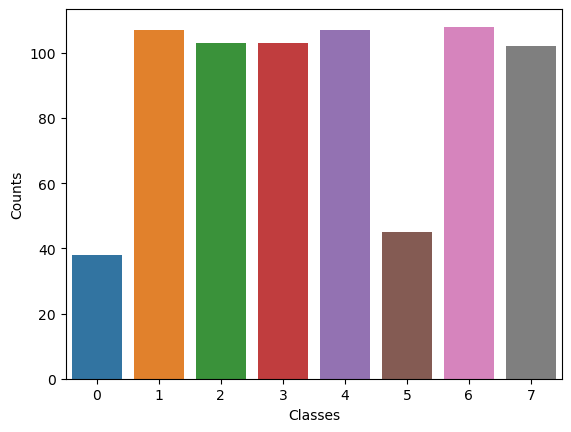

In [17]:
categories, counts = np.unique(np.fromiter([np.argmax(t) for t in y], np.int32), return_counts=True)

#shows classes imbalance
plt.ylabel('Counts')
plt.xlabel('Classes')
sns.barplot(x = categories, y = counts)
plt.show()

Training and validation data splitting

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.15)

print(f"training set input shape", X_train.shape, y_train.shape)
print(f"validation set input shape", X_val.shape, y_val.shape)

training set input shape (606, 96, 96, 3) (606, 8)
validation set input shape (107, 96, 96, 3) (107, 8)


In [19]:
train_data_gen = ImageDataGenerator(rotation_range=180,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    brightness_range=(1, 1.1),
                                    #channel_shift_range=150,
                                    #shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    #vertical_flip=True,
                                    fill_mode='constant',
                                    rescale=1./255)

valid_data_gen = ImageDataGenerator(rescale=1./255)

# Paths
path = os.getcwd()
training_dir = path + '/training'
validation_dir = path + '/validation'

# Training
train_gen = train_data_gen.flow_from_directory(training_dir,
                                               batch_size=batch_size,
                                               target_size=input_size,
                                               classes=classes,
                                               class_mode='categorical',    # Targets are directly converted into one-hot vectors
                                               shuffle=True,
                                               seed=seed)  

# Validation
valid_gen = valid_data_gen.flow_from_directory(validation_dir,
                                               batch_size=batch_size, 
                                               target_size=input_size,
                                               classes=classes,
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=seed)

# Create Datasets objects
train_dataset = tf.data.Dataset.from_generator(lambda: train_gen,
                                               output_types=(tf.float32, tf.uint8),  # TODO: maybe we can set the target to be uint8
                                               output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None, len(classes)]))

train_dataset = train_dataset.repeat()

valid_dataset = tf.data.Dataset.from_generator(lambda: valid_gen, 
                                               output_types=(tf.float32, tf.uint8),
                                               output_shapes=([None, input_shape[0], input_shape[1], input_shape[2]], [None, len(classes)]))

valid_dataset = valid_dataset.repeat()


Found 2829 images belonging to 8 classes.
Found 713 images belonging to 8 classes.


Custom weights for the classes computed by scikit learn

In [23]:
# Compute the class weights in order to balance loss during training
y_numeric = []
for v in y_val:
    y_numeric.append(np.argmax(v))

labels = np.unique(np.fromiter([np.argmax(t) for t in y_val], np.int32))
    
class_weights = dict(enumerate(class_weight.compute_class_weight('balanced', classes=labels, y=y_numeric)))
print(class_weights)

print(f"training set input shape", X_train.shape, y_train.shape)
print(f"validation set input shape", X_val.shape, y_val.shape)


{0: 2.2291666666666665, 1: 0.8359375, 2: 0.8359375, 3: 0.8916666666666667, 4: 0.8359375, 5: 1.9107142857142858, 6: 0.8359375, 7: 0.8916666666666667}
training set input shape (606, 96, 96, 3) (606, 8)
validation set input shape (107, 96, 96, 3) (107, 8)


Image saturation and brightness pre processing enabled

In [24]:
enable_image_preprocessing = False

if(enable_image_preprocessing):
    #adjusting both saturation and constrast of both training and validation
    temp = []
    for img in X_aug_train: 
        temp.append(np.array(tf.image.adjust_contrast(tf.image.adjust_saturation(img, 1.15), 1.02)))
    X_aug_train = np.array(temp)

    temp = []
    for img in X_val: 
        temp.append(np.array(tf.image.adjust_contrast(tf.image.adjust_saturation(img, 1.15), 1.02)))
    X_val = np.array(temp)

### Models definition

Convolutional model defined as a stack of some convolution layers, max pooling, gap and dropout layers.

Fully connected dense layers stacked after the convolutional layers, with no regularization applied. 5 layers of 128 neurons each

In [25]:
# first convolutional model
model = simonnet.build_simonnet_v1(input_shape)

model.summary()

Model: "conv_dense_model_v1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 96, 96, 3)]       0         
                                                                 
 conv1 (Conv2D)              (None, 96, 96, 256)       7168      
                                                                 
 mp1 (MaxPooling2D)          (None, 48, 48, 256)       0         
                                                                 
 conv2 (Conv2D)              (None, 48, 48, 256)       590080    
                                                                 
 mp2 (MaxPooling2D)          (None, 24, 24, 256)       0         
                                                                 
 Conv3 (Conv2D)              (None, 24, 24, 256)       590080    
                                                                 
 gap (GlobalAveragePooling2D  (None, 256)      

## Model Training

In [27]:
# good GPU utilization on my machine with this batch size
batch_size = 64
epochs = 400

# training
history = model.fit(x=train_dataset,
    epochs=epochs,                   # Only indicative since we set "repeat" in training and validation datasets
    batch_size = batch_size,
    validation_data=valid_dataset,
    steps_per_epoch=len(train_gen),
    validation_steps=len(valid_gen),
    class_weight=class_weights,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=30, restore_best_weights=True)]
).history



Epoch 1/400


: 

: 

### Plot training results

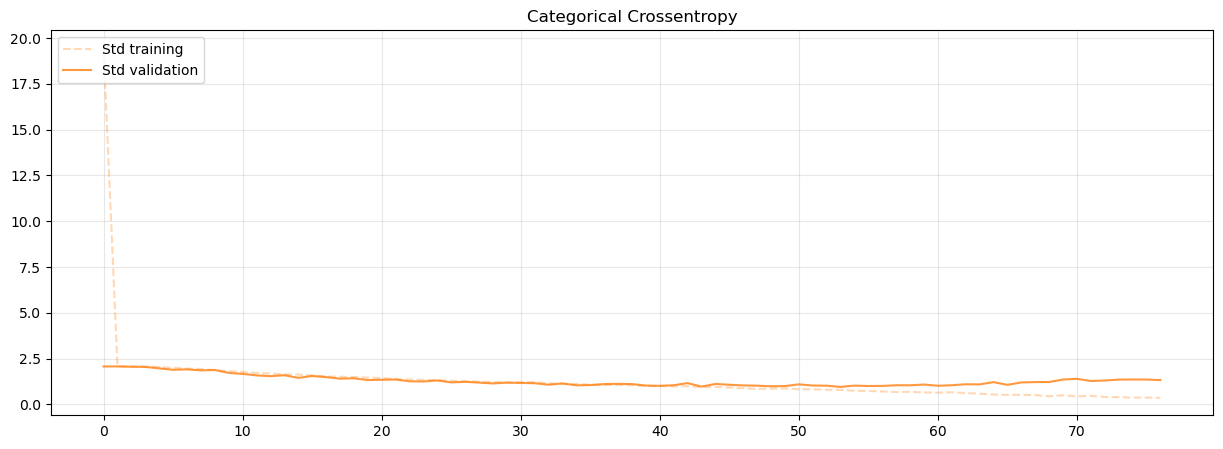

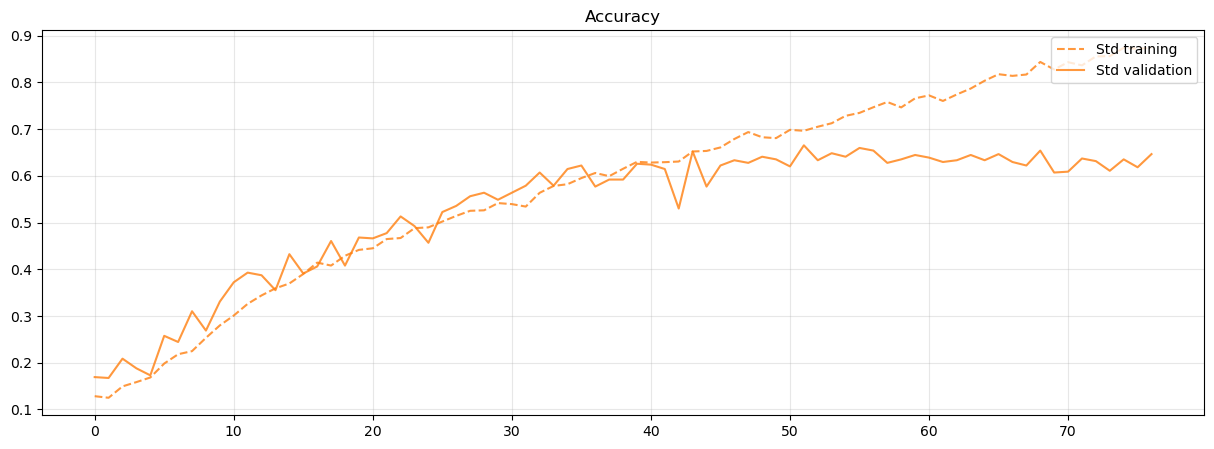

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(history['loss'], label='Std training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(10,5))
plt.plot(history['accuracy'], label='Std training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_accuracy'], label='Std validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper right')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

Plot the confusion matrix (evaluated on the validation set)

Accuracy: 0.6654
Precision: 0.6887
Recall: 0.6481
F1: 0.6582


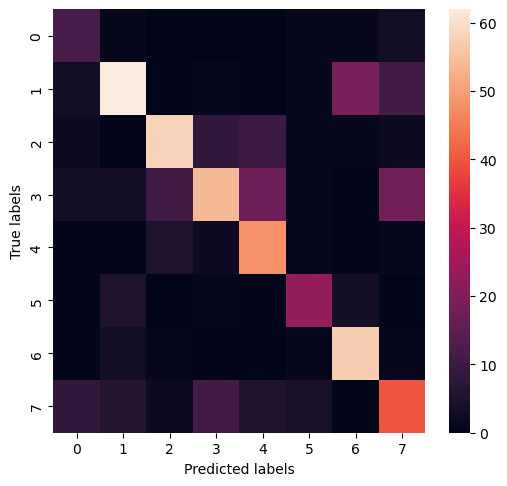

In [ ]:
predictions = model.predict(X_val)
cm = confusion_matrix(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))

accuracy = accuracy_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1))
precision = precision_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
recall = recall_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
f1 = f1_score(np.argmax(y_val, axis=-1), np.argmax(predictions, axis=-1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

plt.figure(figsize=(6,5.5))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.ylabel('True labels')
plt.xlabel('Predicted labels')
plt.show()

Plot one example of an image for each class from the validation set of images.
For each image show the prediction on a bar plot

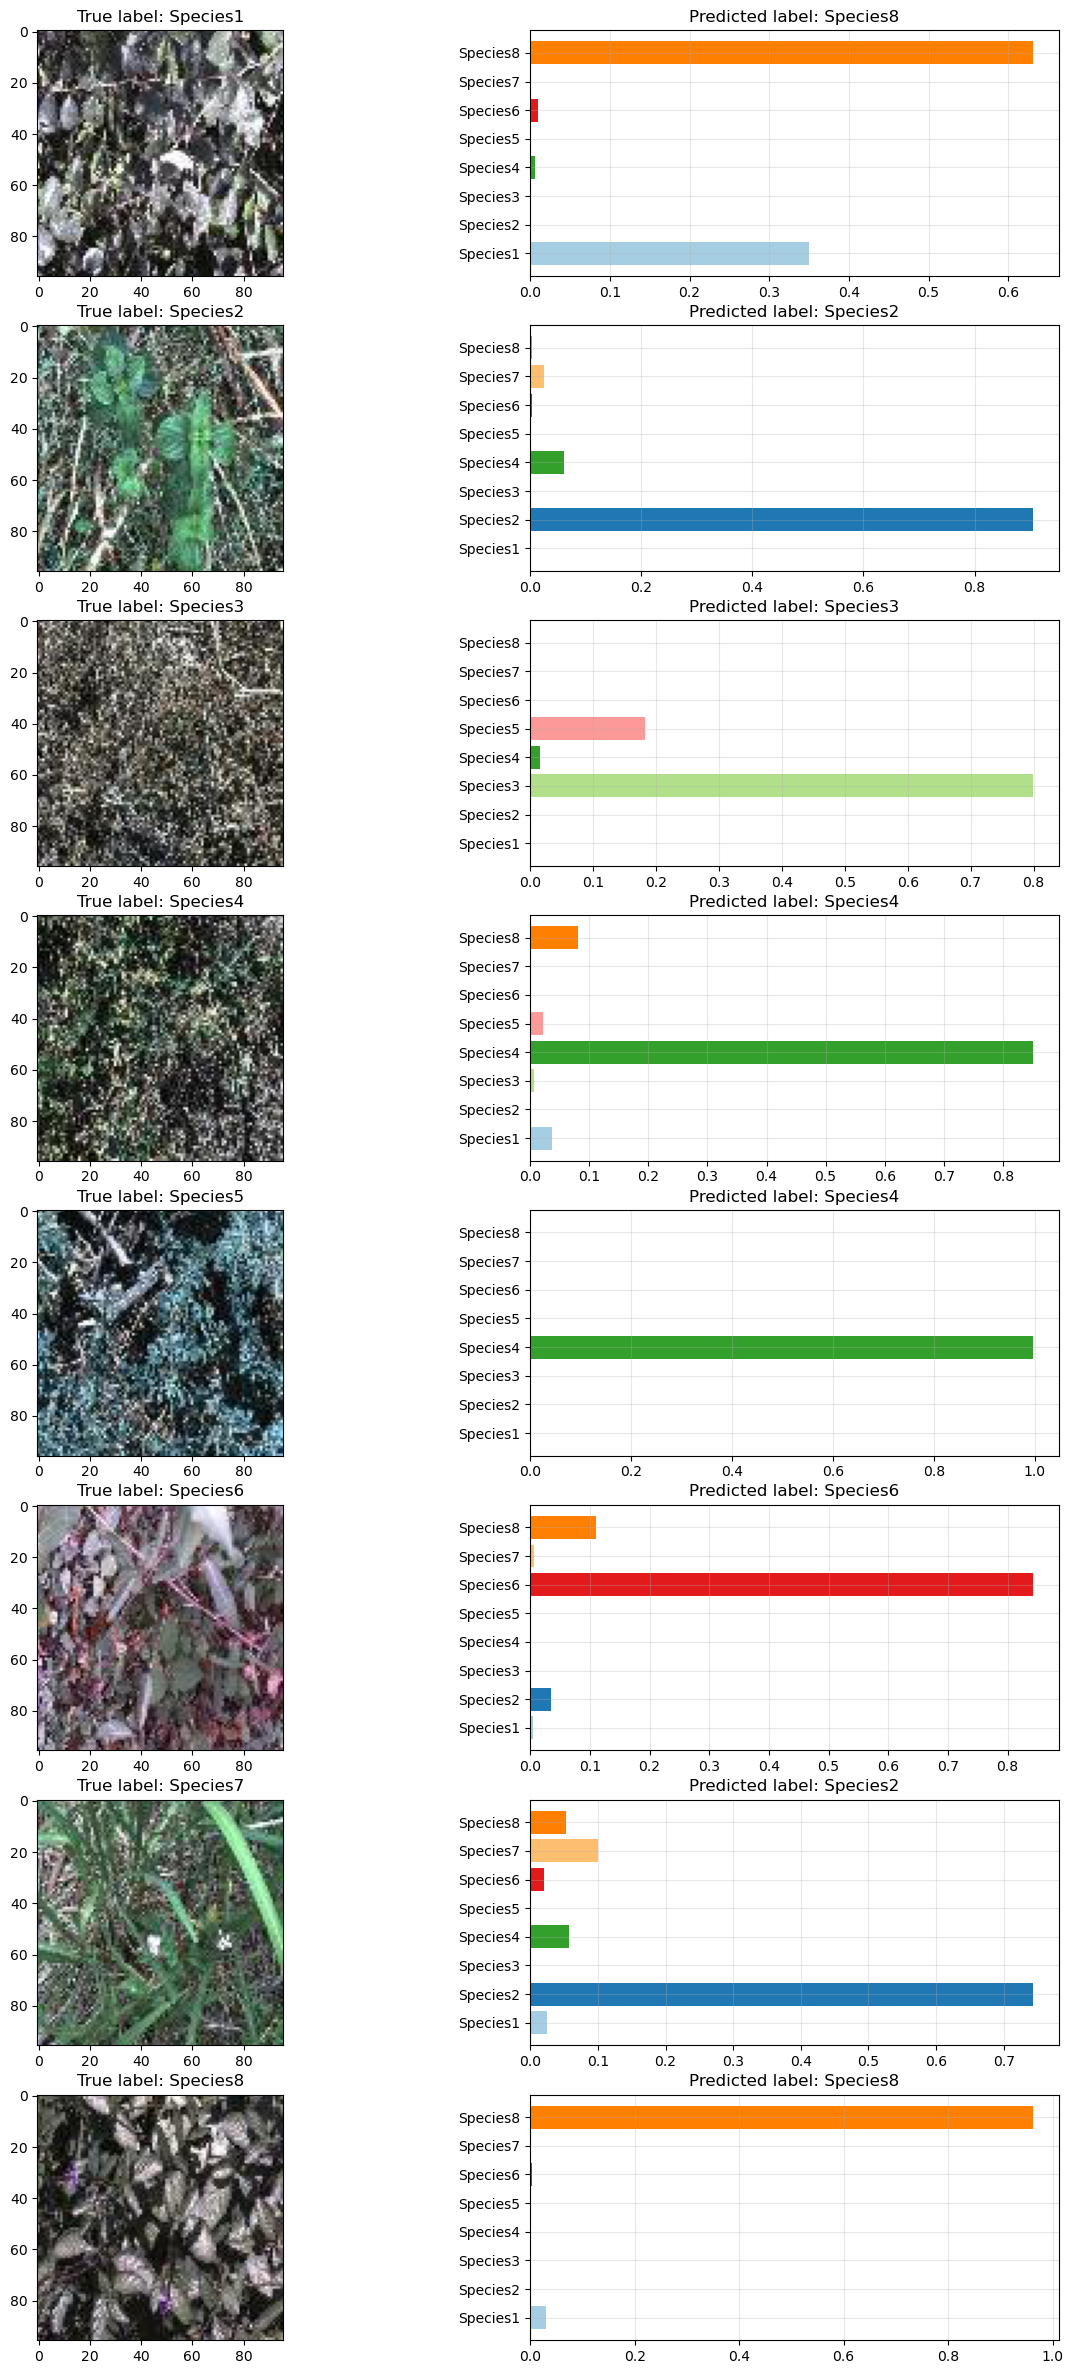

In [ ]:
fig, axes = plt.subplots(8,2)
fig.set_size_inches(15,30)

example_prediction = [0] * 8

for i in range(8):
	example_from_validation = -1
	
	while example_from_validation == -1:
		example_from_validation = random.choice(range(len(X_val)))
		if np.argmax(y_val[example_from_validation]) == i:
			example_prediction[i] = example_from_validation
		else:
			example_from_validation = -1

	predicted = model.predict(X_val[example_prediction[i]].reshape(1, 96, 96, 3))
	
	axes[i, 0].imshow(X_val[example_prediction[i]])
	axes[i, 0].set_title('True label: ' + labels[np.argmax(y_val[example_prediction[i]])])
	axes[i, 1].barh(list(labels.values()), predicted[0], color=plt.get_cmap('Paired').colors)
	axes[i, 1].set_title('Predicted label: ' + labels[np.argmax(predicted)])
	axes[i, 1].grid(alpha=.3)


plt.show()


### Save the model

Here it is not working

In [ ]:
restored_model = tfk.models.load_model('simo_model')

#TODO: not right because validation set can change
restored_loss, restored_acc = restored_model.evaluate(X_val, y_val, verbose=2)
loss, acc = model.evaluate(X_val, y_val, verbose=2)
if acc > restored_acc:  # know that this is conceptually wrong
    print("Model improved!")
    model.save('simo_model')
else:
    print("No improvement!")

17/17 - 2s - loss: 0.2023 - accuracy: 0.9229
17/17 - 1s - loss: 1.0335 - accuracy: 0.6654
No improvement!
